In [7]:
# Importing libraries
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geoplot as gplt 
import geopandas as gpd
import geoplot.crs as gcrs

In [23]:
# Data cleaning

#importing datasets needed
df = pd.read_csv("../FinalDataStory/datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")
districts_df = gpd.read_file("../FinalDataStory/datasets/MO_MoDOT_Districts-20250502T153848Z-1-001/MO_MoDOT_Districts/MO_MoDOT_Districts.shp")

districts_df.head()
df.head()

#get list of columns to pick which ones i will need
col_names = df.columns.to_list()
#print(col_names)

#picking columns that i want
filtered_df = df[["OBJECTID", "STATE_CODE_001", "STRUCTURE_NUMBER_008", "COUNTY_CODE_003", "FACILITY_CARRIED_007"
                 , "LAT_016", "LONG_017", "YEAR_BUILT_027", "TRAFFIC_LANES_ON_028A", "ADT_029", "YEAR_ADT_030", 
                 "BRIDGE_IMP_COST_094", "YEAR_RECONSTRUCTED_106", "FUTURE_ADT_114", "YEAR_OF_FUTURE_ADT_115", 
                 "BRIDGE_CONDITION", "STRUCTURE_LEN_MT_049"]]

#filtered_df["YEAR_BUILT_027"] = pd.to_datetime(filtered_df["YEAR_BUILT_027"])

filtered_df.head()


C:\Users\macke\AppData\Local\Temp\ipykernel_10404\542453312.py:4: DtypeWarning: Columns (99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../FinalDataStory/datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")


,OBJECTID,STATE_CODE_001,STRUCTURE_NUMBER_008,COUNTY_CODE_003,FACILITY_CARRIED_007,LAT_016,LONG_017,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,YEAR_ADT_030,BRIDGE_IMP_COST_094,YEAR_RECONSTRUCTED_106,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,BRIDGE_CONDITION,STRUCTURE_LEN_MT_049
0,290899,29,1,21,MO 6 E,39463723,94473709,1958,6,15423,2023,NaN,1992,20821,2043,F,61.6
1,290900,29,10,25,US 36 E,39440616,93562572,1958,4,8566,2023,NaN,2000,17989,2043,F,6.4
2,290901,29,100,165,IS 29 S,39273317,94471789,1958,4,36821,2023,204.0,0,75483,2043,P,6.6
3,290902,29,1000,77,US 60 E,37072768,93133368,1965,2,15996,2023,NaN,2009,24794,2043,F,120.4
4,290903,29,10000,67,MO 76 E,36581862,92254722,1940,2,419,2023,NaN,0,649,2043,F,15.5


YEAR_BUILT_027
1900    36
1905     1
1910     2
1918     1
1919     1
        ..
2020    98
2021    63
2022    93
2023    85
2024     6
Name: OBJECTID, Length: 110, dtype: int64


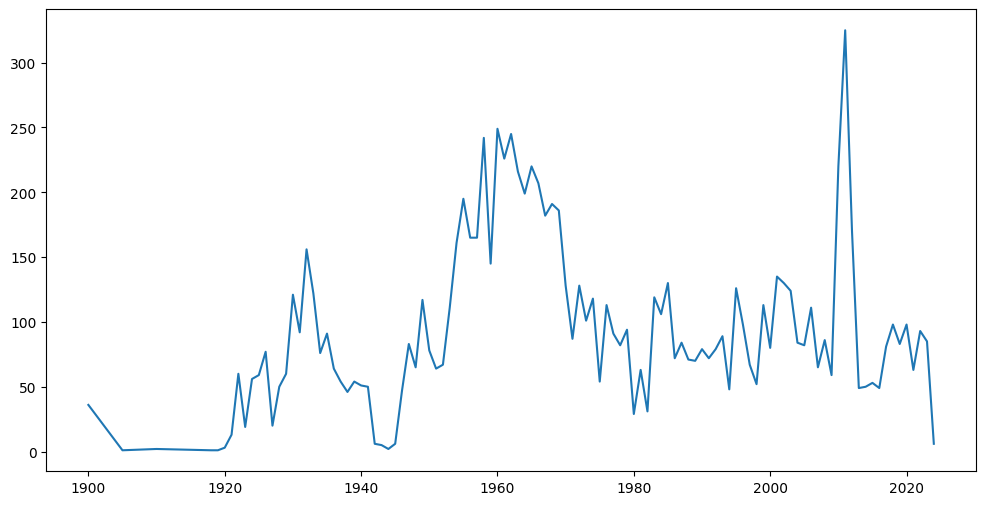

In [25]:
# Time series: Bridges built per year with bridges reconstructed per year

fig, ax = plt.subplots(figsize=(12,6))

bridges_per_year = filtered_df.groupby("YEAR_BUILT_027")["OBJECTID"].count()

print(bridges_per_year)

ax.plot(bridges_per_year.index, bridges_per_year.values)

In [ ]:
# Pie chart: Number of bridges per district, Condition by district

In [ ]:
# Bar Chart: Top 5 highways with number of bridge mileage